In [4]:
import snntorch as snn
import torch
import torch.nn as nn
from snntorch import spikeplot as splt
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import numpy as np
import itertools
# import tonic
# from tonic import DiskCachedDataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
# import network
import torch.optim as optim
import os
from PIL import Image
# import torchvision.transforms.functional as TF
# To get no errors I installed first torch (conda), then tonic (conda) and lastly snntorch (pip)
# Also important to ensure compatibility between pytorch, torchvision and pytorch-cuda/cudatoolkit
# I used pytorch 2.5.1, torchvision 0.20.1 and cudatoolkit 11.1, as cuda needed to be 11.1 due to IsaacSim

%load_ext autoreload
%autoreload 2

In [5]:
print(torch.version.cuda)  # Check PyTorch CUDA version


12.4


# Open Source Dataset

In [3]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

def dvs_animator(spike_data):
    fig, ax = plt.subplots()

    # Create two separate layers: one for positive and one for negative events
    positive_events = spike_data[:, 0]  # Positive events
    negative_events = -spike_data[:, 1]  # Negative events (negated for correct display)

    # Merge events into a single frame with distinct color channels
    dvs_frame = np.zeros((*positive_events.shape, 3))  # RGB Image
    dvs_frame[..., 0] = positive_events  # Red channel (Positive)
    dvs_frame[..., 2] = negative_events  # Blue channel (Negative)
    dvs_frame = torch.tensor(dvs_frame, dtype=torch.float32)
    # Create the animation using the color-encoded frame
    anim = splt.animator(dvs_frame, fig, ax)
    return anim

def fps_animator(frames, fps = 30):
  interval = 1000/fps
  # Create the figure
  fig, ax = plt.subplots()
  img = ax.imshow(frames[0], cmap='gray', vmin=0, vmax=255)  # Ensure grayscale display

  # Update function for animation
  def update(frame_idx):
      img.set_array(frames[frame_idx])
      return [img]

  # Create animation
  anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=interval, blit=True)
  return anim


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [5]:
davisdata = tonic.datasets.DAVISDATA(save_to='./data', recording="shapes_translation")

# dataset = tonic.datasets.POKERDVS(save_to='./data', train=True)
# testset = tonic.datasets.POKERDVS(save_to='./data', train=False)

In [6]:
tonic.datasets.DAVISDATA.sensor_size

(240, 180, 2)

In [7]:
# Here we define the time window.

frame_transform = tonic.transforms.Compose([tonic.transforms.Denoise(filter_time=10000), 
                                    tonic.transforms.ToFrame(
                                        sensor_size=tonic.datasets.DAVISDATA.sensor_size,
                                        time_window=10000)
                                     ])
cached_davisdata = DiskCachedDataset(davisdata, transform=frame_transform, cache_path='./cache/davisdata/train')

In [8]:
batch_size = 8

trainloader = DataLoader(cached_davisdata, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

# testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [9]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct
    
    accuracy = (running_accuracy / running_length)

    return accuracy.item()


In [10]:
sample = davisdata[0]

In [11]:
sample_transformed = frame_transform(sample[0][0])


In [12]:
sample_transformed = torch.tensor(sample_transformed, dtype=torch.float32)

In [13]:
sample_transformed.size()[0]

5973

In [14]:
import os

# Path to your locally extracted ffmpeg.exe
ffmpeg_bin_folder = r"C:\Users\realenriquem\ffmpeg-2025-02-10-git-a28dc06869-essentials_build\bin"

# Tell matplotlib (and other libraries) to use your local ffmpeg
os.environ["PATH"] = ffmpeg_bin_folder + os.pathsep + os.environ.get("PATH", "")
import matplotlib.animation as matanimation
print(matanimation.writers.list()) 

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


In [ ]:
animation = dvs_animator(sample_transformed)
HTML(animation.to_html5_video())

KeyboardInterrupt: 

In [31]:
# plot distinct va
# sample_transformed[0][0].size()
torch.unique(sample_transformed[0][1])

tensor([0., 1., 2.])

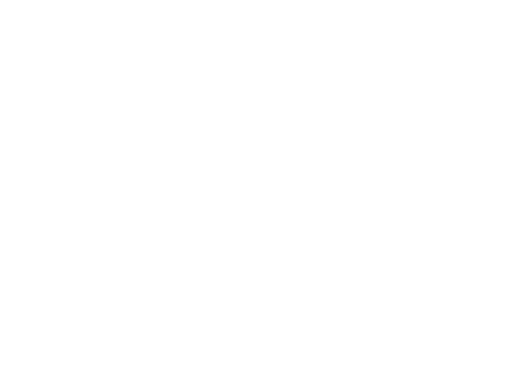

In [26]:
video = sample[0][2]['frames']
video = torch.tensor(video, dtype=torch.float32)
animation = fps_animator(video)
HTML(animation.to_html5_video())

# Ball Tracker
## Dataset Creation

In [51]:
dataset_folder = 'classical_tracking_dataset'
csv_path = os.path.join(dataset_folder, 'labels.csv')
image_dir = os.path.join(dataset_folder, 'frames')
trainset = network.BallTrackingDataset(csv_path, image_dir, split='train', dataset_type="ball", augment=True)
testset = network.BallTrackingDataset(csv_path, image_dir, split='test', dataset_type="ball", augment=False)
batch_size = 8
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Final dataset split='train' size: 752
Loaded 1862 rows from classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Final dataset split='test' size: 162


In [40]:
image_path = os.path.join(image_dir, '13-38-07_17_0075.png')
image = Image.open(image_path)

image.size

(800, 600)

## Model Training

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [ ]:
# Instantiate model
model = network.SCNN_Tracker(num_x_bins=800, num_y_bins=600).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using cpu device
Flattened feature size: 480000


In [52]:
network.train_model(model, trainloader, optimizer, device, num_epochs=1)

KeyboardInterrupt: 

In [49]:
trajectory

array([[ 6.22222222,  3.75757576,  0.5       ],
       [ 6.19782128,  3.65769738,  0.60743756],
       [ 6.17342033,  3.557819  ,  0.71268252],
       [ 6.14901939,  3.45794062,  0.81573488],
       [ 6.12461845,  3.35806224,  0.91659463],
       [ 6.1002175 ,  3.25818386,  1.01526178],
       [ 6.07581656,  3.15830548,  1.11173633],
       [ 6.05141562,  3.0584271 ,  1.20601827],
       [ 6.02701467,  2.95854872,  1.29810761],
       [ 6.00261373,  2.85867034,  1.38800435],
       [ 5.97821278,  2.75879196,  1.47570848],
       [ 5.95381184,  2.65891358,  1.56122001],
       [ 5.9294109 ,  2.55903521,  1.64453894],
       [ 5.90500995,  2.45915683,  1.72566526],
       [ 5.88060901,  2.35927845,  1.80459898],
       [ 5.85620807,  2.25940007,  1.8813401 ],
       [ 5.83180712,  2.15952169,  1.95588861],
       [ 5.80740618,  2.05964331,  2.02824452],
       [ 5.78300524,  1.95976493,  2.09840783],
       [ 5.75860429,  1.85988655,  2.16637853],
       [ 5.73420335,  1.76000817,  2.232

In [9]:
t_flight

0.434696485716488

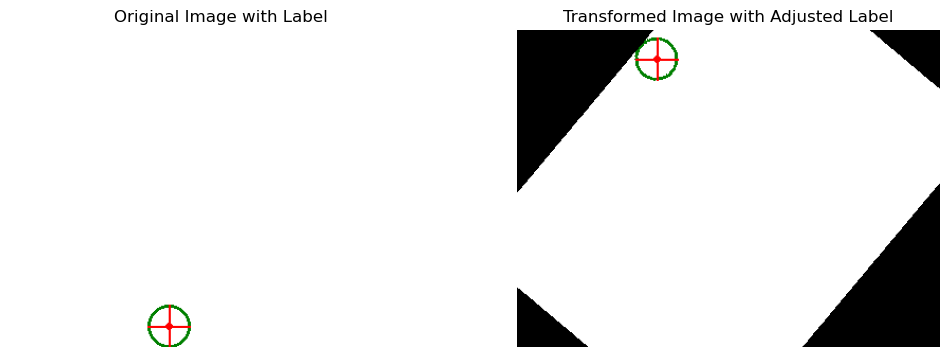

In [25]:
import torchvision.transforms.functional as TF
import math
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np

# Create a blank test image (white background)
width, height = 400, 300
image = Image.new("RGB", (width, height), color="white")

# Define the original ball parameters (position and radius)
orig_x, orig_y, r = 150, 20, 20
r_dot = 3

minus_y = height - orig_y
# Create a copy of the image and draw the original ball label on it
original_with_circle = image.copy()
draw_circle = ImageDraw.Draw(original_with_circle)
draw_circle.ellipse((orig_x - r, minus_y - r, orig_x + r, minus_y + r), outline="green", width=3)

original_with_label = original_with_circle.copy()
draw_orig = ImageDraw.Draw(original_with_label)
draw_orig.ellipse((orig_x - r_dot, minus_y - r_dot, orig_x + r_dot, minus_y + r_dot), outline="red", width=3)
# Horizontal line
draw_orig.line(
    [(orig_x - r, minus_y), (orig_x + r, minus_y)],
    fill="red",
    width=2
)

# Vertical line
draw_orig.line(
    [(orig_x, minus_y - r), (orig_x, minus_y + r)],
    fill="red",
    width=2
)

# Set transformation parameters (for testing, we fix these values)
do_hflip = True
do_vflip = True
angle = 50  # degrees rotation

# Copy the original image for transformation
transformed = original_with_circle.copy()

# We'll also start with the original label coordinates
x, y = orig_x, orig_y

# Apply horizontal flip if enabled and update x-coordinate accordingly.
if do_hflip:
    transformed = TF.hflip(transformed)
    x = transformed.width - x

# Apply vertical flip if enabled and update y-coordinate accordingly.
if do_vflip:
    transformed = TF.vflip(transformed)
    y = transformed.height - y

# Rotate the image by the specified angle.
transformed = TF.rotate(transformed, angle)

# Adjust the label coordinates for the rotation.
# We rotate the point (x, y) around the center of the image.
cx, cy = transformed.width / 2, transformed.height / 2
angle_rad = math.radians(angle)
# print(angle_rad/np.pi)
# print(math.cos(angle_rad))
# print(math.sin(angle_rad))
x_new = math.cos(angle_rad) * (x - cx) - math.sin(angle_rad) * (y - cy) + cx # CAREFUL WITH THIS!! Y axis is inverted in images
y_new = math.sin(angle_rad) * (x - cx) + math.cos(angle_rad) * (y - cy) + cy
x, y = x_new, y_new

minus_y = transformed.height - y

# Draw the adjusted label on the transformed image.
transformed_with_label = transformed.copy()
draw_trans = ImageDraw.Draw(transformed_with_label)
draw_trans.ellipse((x - r_dot, minus_y - r_dot, x + r_dot, minus_y + r_dot), outline="red", width=3)
# Horizontal
draw_trans.line(
    [(x - r, minus_y), (x + r, minus_y)],
    fill="red",
    width=2
)
# Vertical
draw_trans.line(
    [(x, minus_y - r), (x, minus_y + r)],
    fill="red",
    width=2
)
# r_circle = np.sqrt((orig_x-cx)**2 + (orig_y-cy)**2)
# draw_trans.ellipse((cx - r_circle, cy - r_circle, cx + r_circle, cy + r_circle), outline="blue", width=3)
# print(orig_x, orig_y)
# print(x, y)

# Plot the original and transformed images side by side.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original_with_label)
axs[0].set_title("Original Image with Label")
axs[0].axis("off")
axs[1].imshow(transformed_with_label)
axs[1].set_title("Transformed Image with Adjusted Label")
axs[1].axis("off")
plt.show()
